In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import geopandas as gpd
import os 

In [2]:
# geopandas 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [5]:
# import data
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
files = os.listdir('../data/kml_files')
geography_information = []
for file in files: 
    d = gpd.read_file(f'../data/kml_files/{file}', driver='KML')
    geography_information.append(d)
geography_information = pd.concat(geography_information)
geography_information = geography_information[['Name', 'geometry']]
geography_centroid = geography_information.assign(geometry = lambda x: x['geometry'].centroid)

/tmp/ipykernel_15890/3150390882.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geography_centroid = geography_information.assign(geometry = lambda x: x['geometry'].centroid)


In [8]:
geography_information.head(5) # only 151 rows 

,Name,geometry
0,The Khazneh,"MULTIPOLYGON (((35.45148 30.32248, 35.45165 30..."
0,Judean Desert oasis,"MULTIPOLYGON (((35.38822 31.46896, 35.38769 31..."
0,West Lake,"MULTIPOLYGON (((120.14724 30.23157, 120.14908 ..."
0,Jebel Barkal,"MULTIPOLYGON (((31.82797 18.55335, 31.81870 18..."
0,Island of Ireland,"MULTIPOLYGON (((-7.37010 55.41123, -6.84276 55..."


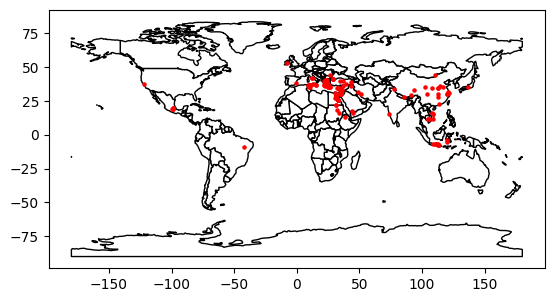

In [4]:
# plot 
base = world.plot(color = 'white', edgecolor = 'black')
geography_centroid.plot(ax=base, marker='o', color='red', markersize=5)
plt.show();

In [7]:
# match on our data?
data_raw = pd.read_csv('../data/raw/drh_20221019.csv')
data_geography = data_raw[['entry_name', 'entry_id', 'region_name', 'region_id', 'region_tags', 'region_desc']].drop_duplicates()
data_geography.head(5)

/tmp/ipykernel_15890/2012597612.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  data_raw = pd.read_csv('../data/raw/drh_20221019.csv')


,entry_name,entry_id,region_name,region_id,region_tags,region_desc
0,Roman private religion,217,Italy,498,"Europe[3], Europe[3] -> Southern Europe[73]","Italy south of the Alps, including Sicily, Sar..."
45,The Royal Cache - Theban Tomb 320,1102,Deir el-Bahri,1244,"Africa[14], Africa[14] -> Northern Africa[64],...",Deir el-Bahri is located on the west bank of t...
47,Liumen (Liu School),1386,Sichuan and surrounding areas,1541,"Asia[1], China[504], East Asia[520], Sichuan[7...",Sichuan and surrounding areas from the Qing dy...
122,Sokoto,1511,Sokoto,1673,"Africa[14], Africa[14] -> Western Africa[65], ...","Sokoto around 1870, during the reign of Ahmadu..."
151,Order of the Hermits of St Augustine (Augustin...,1521,Italian peninsula,1683,Italy[531],"Italian peninsula, 1256-1400."
